In [71]:
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import f1_score, roc_auc_score, recall_score, accuracy_score, precision_score
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
matplotlib.rcParams['figure.figsize'] = (11.0, 8.0)

import warnings
warnings.filterwarnings('ignore')


In [72]:
# Importing Data
df = pd.read_csv('./address_data_combined.csv')
X = df.drop(columns=['Address', 'FLAG'])
y = df['FLAG']
X_train_full, X_test, y_train_full, y_test = train_test_split(X, y, test_size=0.25, random_state=42, stratify=y)

# Feature Engineering
columns = ['Avg min between sent tnx', 'Avg min between received tnx',
           'Time Diff between first and last (Mins)',
           'Unique Received From Addresses', 'min value received',
           'max value received ', 'avg val received', 'min val sent',
           'avg val sent', 'total transactions (including tnx to create contract',
           'total ether received', 'total ether balance']

scaler = MinMaxScaler()

In [73]:
# Log Transformation for Skewed Data
for c in columns:
    X_train_full[c] = X_train_full[c].apply(lambda x: np.log(x) if x > 0 else 0)
    X_test[c] = X_test[c].apply(lambda x: np.log(x) if x > 0 else 0)

# Scaling
X_train_full = scaler.fit_transform(X_train_full)
X_test = scaler.transform(X_test)

# Model Configuration
model = tf.keras.Sequential([
    tf.keras.layers.Dense(64, activation='relu', input_dim=X_train_full.shape[1]),  # Increased neurons
    tf.keras.layers.Dropout(0.1),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dropout(0.1),
    tf.keras.layers.Dense(16, activation='relu'),
    tf.keras.layers.Dropout(0.1),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

# Compile the model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Implement Early Stopping
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)


/home/kagwe/.pyenv/versions/3.11.5/lib/python3.11/site-packages/keras/src/layers/core/dense.py:85: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [38]:
# model = tf.keras.models.Sequential([
#     tf.keras.layers.Dense(128, activation='relu', input_dim=X_train_full.shape[1]),
#     tf.keras.layers.Dense(64, activation='relu'),
#     tf.keras.layers.Dense(32, activation='relu'),
#     tf.keras.layers.Dense(16, activation='relu'),
#     tf.keras.layers.Dense(8, activation='relu'),
#     tf.keras.layers.Dense(1, activation='sigmoid')
# ])

# model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
#               loss='binary_crossentropy',
#               metrics=['accuracy'])


In [74]:
# Fit the model
history = model.fit(
    X_train_full, 
    y_train_full, 
    epochs=100, 
    batch_size=32, 
    validation_split=0.2, 
    callbacks=[early_stopping],
    verbose=2
)

# Evaluation

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)

Epoch 1/100
248/248 - 2s - 8ms/step - accuracy: 0.6861 - loss: 0.5736 - val_accuracy: 0.8274 - val_loss: 0.4085
Epoch 2/100
248/248 - 1s - 3ms/step - accuracy: 0.8290 - loss: 0.3887 - val_accuracy: 0.8789 - val_loss: 0.2984
Epoch 3/100
248/248 - 1s - 3ms/step - accuracy: 0.8540 - loss: 0.3423 - val_accuracy: 0.8900 - val_loss: 0.2761
Epoch 4/100
248/248 - 1s - 2ms/step - accuracy: 0.8669 - loss: 0.3192 - val_accuracy: 0.8890 - val_loss: 0.2616
Epoch 5/100
248/248 - 1s - 2ms/step - accuracy: 0.8702 - loss: 0.3044 - val_accuracy: 0.8951 - val_loss: 0.2536
Epoch 6/100
248/248 - 1s - 3ms/step - accuracy: 0.8706 - loss: 0.3056 - val_accuracy: 0.9041 - val_loss: 0.2419
Epoch 7/100
248/248 - 1s - 3ms/step - accuracy: 0.8781 - loss: 0.2926 - val_accuracy: 0.8951 - val_loss: 0.2449
Epoch 8/100
248/248 - 1s - 2ms/step - accuracy: 0.8844 - loss: 0.2834 - val_accuracy: 0.9051 - val_loss: 0.2314
Epoch 9/100
248/248 - 1s - 2ms/step - accuracy: 0.8827 - loss: 0.2789 - val_accuracy: 0.9112 - val_loss:

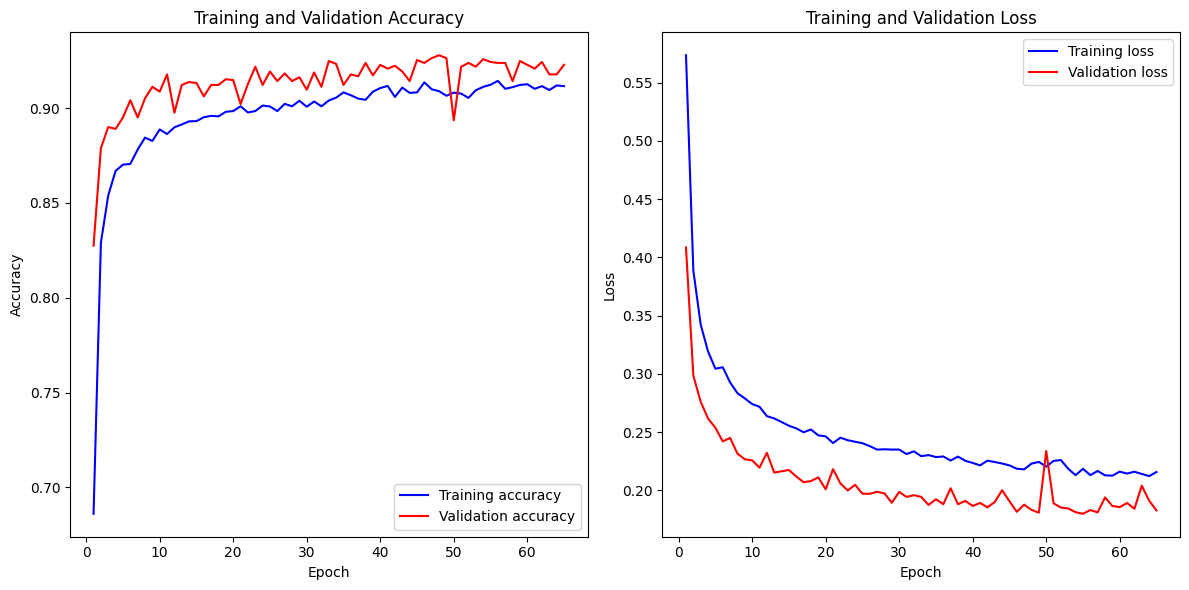

In [75]:
# Plot training & validation accuracy values
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs, acc, 'b', label='Training accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

In [65]:
loss, accuracy = model.evaluate(X_test, y_test)
print(f'Test Accuracy: {accuracy}')

# Predictions
y_pred_proba = model.predict(X_test).flatten()
y_pred = (y_pred_proba > 0.5).astype(int)

# Calculating additional metrics
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred_proba)  # roc_auc_score expects probability scores

print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1 Score: {f1}')
print(f'ROC AUC Score: {roc_auc}')


111/111 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9253 - loss: 0.2011
Test Accuracy: 0.918903648853302
111/111 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Precision: 0.9122160834868017
Recall: 0.9116564417177914
F1 Score: 0.9119361767413316
ROC AUC Score: 0.9737382177415985
